In [1]:
%matplotlib inline

# Feathering two data cubes

A general overview of all steps to check when feathering single dish and interferometric data together. It's written for data cubes, though the general approach should hold for continuum images, too (modulo additional effects from varying bandpasses).

Steps
-----
1. Match spectral resolution -- regrid/smooth to the coarsest resolution between the cubes
2. Spatial registration -- reproject and match spatial resolution. Check for spatial offsets
3. Apply equal spatial masking and/or weighting
    (a) mask by PB coverage of the interferometric data; 
    (b) weight edges of SD and interferometer by the PB values -- using this like an apodizing kernel
4. Calculate uv-overlap statistics
5. Measure the flux ratio
6. Feather the cubes together with the appropriate flux scaling.



In [2]:
import astropy.units as u
from astropy.convolution import Gaussian1DKernel

from spectral_cube import SpectralCube
from radio_beam import Beam

from regions import Regions

import matplotlib.pyplot as plt



from uvcombine.scale_factor import find_scale_factor

from cube_analysis.feather_cubes import feather_compare_cube


In [3]:
from pathlib import Path

sd_data_path = Path("/Users/ekoch/storage/LGLBS/feathering_tests/")
vla_data_path = Path("/Users/ekoch/storage/LGLBS/C+D_HI_2023/")


In [4]:
vla_cube = SpectralCube.read(vla_data_path / "ngc6822_C+D_hilores.fits")
vla_cube.allow_huge_operations = True

# Nick's reprocessed and gridded GBT cube.
gbt_cube = SpectralCube.read(sd_data_path / "NGC6822-center_cube.fits")

# Use the proper beam model size, not the one in the header!
gbt_beam_model = Beam(area=3.69e5 *u.arcsec**2)
gbt_beam_model.major.to(u.arcmin)

gbt_cube = gbt_cube.with_beam(gbt_beam_model)
gbt_cube = gbt_cube.with_spectral_unit(u.km / u.s, velocity_convention='radio')


### 1. Match spectral resolution -- regrid/smooth to the coarsest resolution between the cubes


In [5]:
gbt_cube = gbt_cube.with_spectral_unit(u.m / u.s, velocity_convention='radio')

fwhm_factor = np.sqrt(8*np.log(2))
current_resolution = np.abs(np.diff(gbt_cube.spectral_axis)[0]).to(u.km / u.s)
target_resolution = np.abs(np.diff(vla_cube.spectral_axis)[0]).to(u.km / u.s)

gaussian_width = ((target_resolution**2 - current_resolution**2)**0.5 /
                  current_resolution / fwhm_factor)
print(gaussian_width)
kernel = Gaussian1DKernel(gaussian_width.value)
gbt_cube_specsmooth = gbt_cube.spectral_smooth(kernel)


gbt_cube_specinterp = gbt_cube_specsmooth.spectral_interpolate(vla_cube.spectral_axis)

0.530633586959852


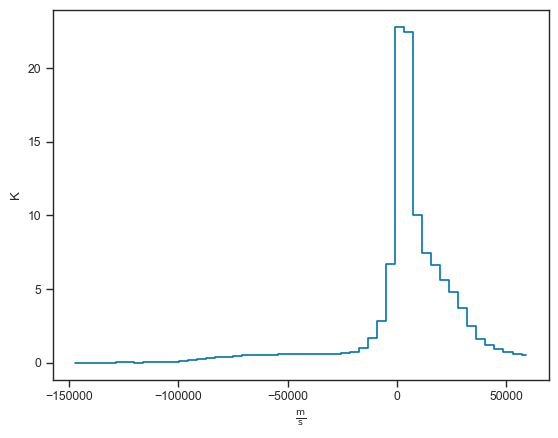

In [6]:
gbt_cube_specinterp.mean(axis=(1, 2)).quicklook()

/Users/ekoch/Library/CloudStorage/Dropbox/code_development/radio_astro_tools/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: Mean of empty slice
  out = function(self._get_filled_data(fill=fill,


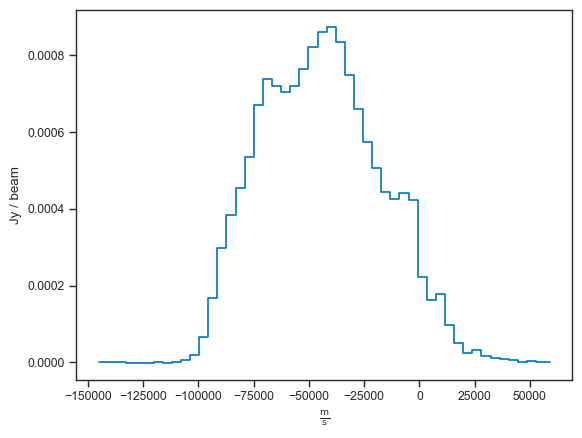

In [7]:
vla_cube.mean(axis=(1, 2)).quicklook()

### 2. Spatial registration -- reproject and match spatial resolution. Check for spatial offsets

In [8]:
from cube_analysis.register_cubes import cube_registration

In [9]:
# To speed up the computation, select a velocity range corresponding to the target of interest.

chan_min = vla_cube.closest_spectral_channel(-75 * u.km/u.s)
chan_max = vla_cube.closest_spectral_channel(-25 * u.km/u.s)

if chan_min > chan_max:
    chan_min, chan_max = chan_max, chan_min
    
print(chan_min, chan_max)

spec_slicer = slice(chan_min, chan_max)


20 33


In [10]:
# This function will smooth to the lowsest resolution and reproject per channel
# https://github.com/e-koch/CubeAnalysis/blob/master/cube_analysis/register_cubes.py#L58

spatial_offsets = cube_registration(gbt_cube_specinterp[spec_slicer],
                                    vla_cube[spec_slicer],
                                    verbose=True, num_cores=1,
                                    restfreq=1.42040575177 * u.GHz,
                                    check_specaxis=True,)


/Users/ekoch/Library/CloudStorage/Dropbox/code_development/CubeAnalysis/cube_analysis/progressbar.py:320: RuntimeWarning: divide by zero encountered in long_scalars
  if (i % chunksize) == 0:
/Users/ekoch/Library/CloudStorage/Dropbox/code_development/CubeAnalysis/cube_analysis/progressbar.py:320: RuntimeWarning: divide by zero encountered in long_scalars
  if (i % chunksize) == 0:
/Users/ekoch/Library/CloudStorage/Dropbox/code_development/CubeAnalysis/cube_analysis/progressbar.py:320: RuntimeWarning: divide by zero encountered in long_scalars
  if (i % chunksize) == 0:
/Users/ekoch/Library/CloudStorage/Dropbox/code_development/CubeAnalysis/cube_analysis/progressbar.py:320: RuntimeWarning: divide by zero encountered in long_scalars
  if (i % chunksize) == 0:
/Users/ekoch/Library/CloudStorage/Dropbox/code_development/CubeAnalysis/cube_analysis/progressbar.py:320: RuntimeWarning: divide by zero encountered in long_scalars
  if (i % chunksize) == 0:
/Users/ekoch/Library/CloudStorage/Dropbo

In [11]:
spatial_offsets[:, 0]

array([-0.16666667, -0.05555556, -0.        ,  0.05555556,  0.11111111,
        0.16666667,  0.16666667,  0.27777778,  0.33333333,  0.33333333,
        0.38888889,  0.5       ,  0.66666667])

Text(0.5, 0, 'RA pixel offset')

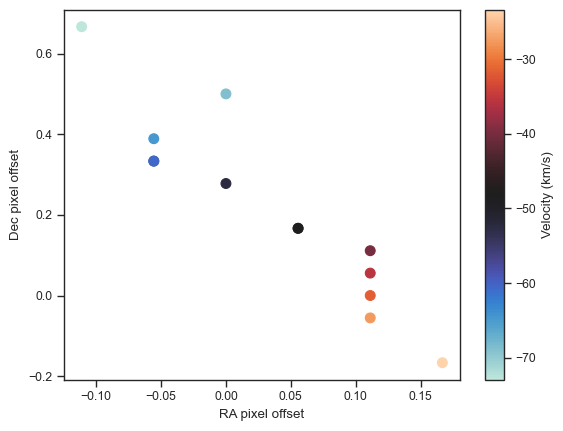

In [12]:
import seaborn as sns


# cmap = sns.cubehelix_palette(as_cmap=True)
cmap = sns.color_palette("icefire", as_cmap=True)

f, ax = plt.subplots()
points = ax.scatter(spatial_offsets[:, 1],
                    spatial_offsets[:, 0], 
                    c=vla_cube[spec_slicer].spectral_axis.to(u.km / u.s).value, 
                    s=50, 
                    cmap=cmap)
f.colorbar(points, label="Velocity (km/s)")

ax.set_ylabel("Dec pixel offset")
ax.set_xlabel("RA pixel offset")

# Plot spatial offset as function of the channel:
# for yx in spatial_offsets:
#     plt.scatter(yx[0], yx[1])


This is far smaller than a single GBT pixel, and thus is within uncertainty for the GBT primary beam.

### 3. Apply equal spatial masking and/or weighting

Consider doing one of two:

1. mask by PB coverage of the interferometric data; 
2. weight edges of SD and interferometer by the PB values -- using this like an apodizing kernel

Demonstrating (1) here.

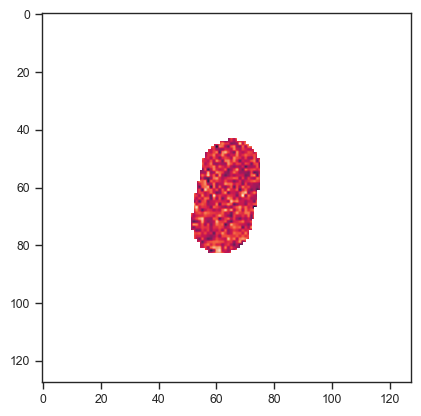

In [13]:
vla_reproj_plane = vla_cube[0].reproject(gbt_cube_specinterp[0].header)

vla_reproj_plane.quicklook()

In [14]:
gbt_cube_specinterp_masked = gbt_cube_specinterp.with_mask(np.isfinite(vla_reproj_plane)).minimal_subcube(spatial_only=True)

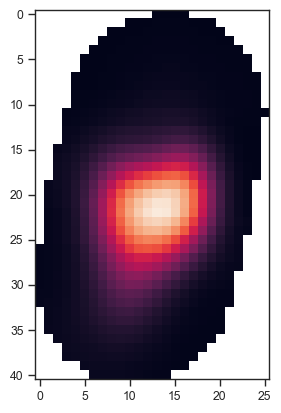

In [15]:
# Visualize the sliced cube:

gbt_cube_specinterp_masked[spec_slicer].moment0().quicklook()

### 4. Calculate uv-overlap statistics

In [16]:
# Take 40 m as the shortest VLA baseline
# It's technically 25 m, but 40 m seems to work better based on the archival M31 and M33.

hi_freq = 1.42040575 * u.GHz
las = (hi_freq.to(u.cm, u.spectral()) / (40 * u.m)).to(u.arcsec, u.dimensionless_angles())


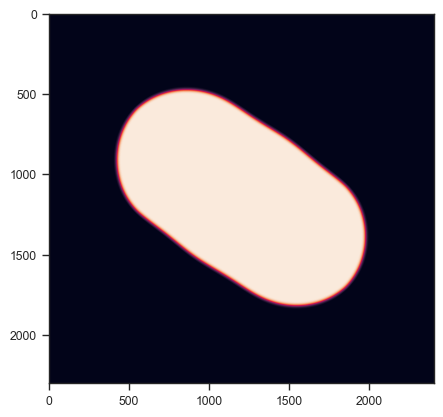

In [17]:
def taper_weights(pb_plane,
                erosion_interations=5):

    # mask = np.logical_or(np.isfinite(pb_plane), pb_plane > 0.)
    mask = pb_plane > 0.

    if erosion_interations > 0:
        mask = nd.binary_erosion(mask, iterations=erosion_interations)

    smoothed_weights = nd.gaussian_filter(mask.astype(float), sigma=erosion_interations/2.)

    weight_arr = pb_plane * smoothed_weights

    return weight_arr

weights = taper_weights(np.isfinite(vla_cube[0]), erosion_interations=20)

plt.imshow(weights)


In [18]:
radii, ratios, high_pts, low_pts, chan_out = \
            feather_compare_cube(vla_cube.to(u.K),
                                 gbt_cube_specinterp_masked.to(u.K),
                                 las,
                                 lowresfwhm=None,
                                 num_cores=1,
                                 chunk=250,
                                 verbose=True,
                                 weights=weights,
                                 relax_spectral_check=False,
                                 spec_check_kwargs={'rtol': 0.01})

INFO: On chunk 1 of 1 [cube_analysis.feather_cubes]


/Users/ekoch/anaconda3/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/ekoch/Library/CloudStorage/Dropbox/code_development/CubeAnalysis/cube_analysis/progressbar.py:320: RuntimeWarning: divide by zero encountered in long_scalars
  if (i % chunksize) == 0:
/Users/ekoch/anaconda3/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/ekoch/Library/CloudStorage/Dropbox/code_development/CubeAnalysis/cube_analysis/progressbar.py:320: RuntimeWarning: divide by zero encountered in long_scalars
  if (i % chunksize) == 0:
/Users/ekoch/anaconda3/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method,

In [19]:
# high_pts[-1]

# low_pts[-1]

/Users/ekoch/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:2694: UserWarning: df_model + k_constant differs from nparams
  warnings.warn("df_model + k_constant differs from nparams")
/Users/ekoch/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:2696: UserWarning: df_resid differs from nobs - nparams
  warnings.warn("df_resid differs from nobs - nparams")


Optimization terminated successfully.
         Current function value: 1.751783
         Iterations: 45
         Function evaluations: 85
0.69+/-0.01


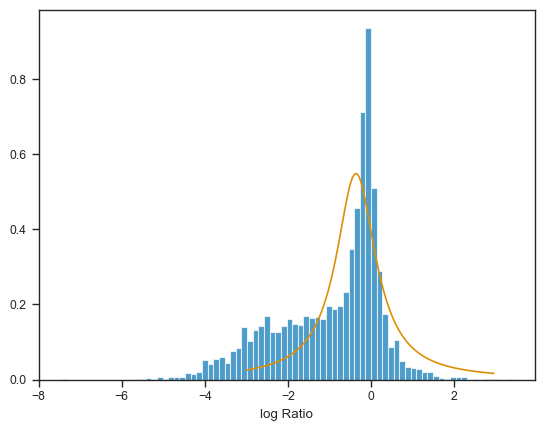

In [20]:
# Using the entire spectral axis:

sc_factor, sc_err = find_scale_factor(np.hstack(low_pts[:-1]),
                                      np.hstack(high_pts[:-1]),
                                      method='distrib',
                                      verbose=True)
print(f"{sc_factor:.2f}+/-{sc_err:.2f}")

Optimization terminated successfully.
         Current function value: -0.149025
         Iterations: 41
         Function evaluations: 79
0.92+/-0.00


/Users/ekoch/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:2694: UserWarning: df_model + k_constant differs from nparams
  warnings.warn("df_model + k_constant differs from nparams")
/Users/ekoch/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:2696: UserWarning: df_resid differs from nobs - nparams
  warnings.warn("df_resid differs from nobs - nparams")


(-1.0, 1.0)

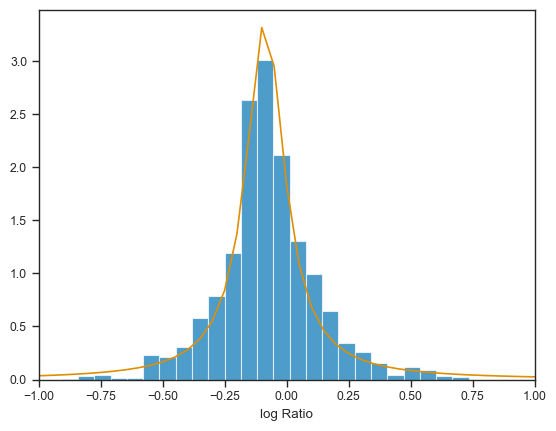

In [21]:
# Using only the velocity range of the target:

sc_factor, sc_err = find_scale_factor(np.hstack(low_pts[spec_slicer]),
                                      np.hstack(high_pts[spec_slicer]),
                                      method='distrib',
                                      verbose=True)
print(f"{sc_factor:.2f}+/-{sc_err:.2f}")

plt.xlim([-1, 1])

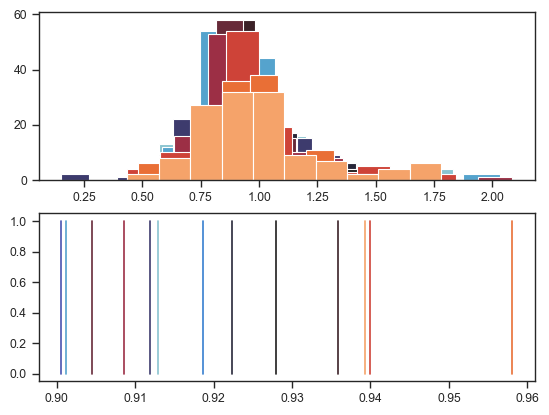

In [22]:
# Check for a dependence on velocity:

fig, axs = plt.subplots(2, 1, sharex=False)

cmap = sns.color_palette("icefire", n_colors=chan_max - chan_min, as_cmap=False)


for ii, this_ratio in enumerate(ratios[spec_slicer]):
    
    _ = axs[0].hist(this_ratio, label=f"{ii}", color=cmap[ii])
    
    axs[1].plot(2 * [np.median(this_ratio)], [0, 1], color=cmap[ii])
    

In [23]:
# print(cmap)

/Users/ekoch/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/ekoch/Library/CloudStorage/Dropbox/code_development/TurbuStat/turbustat/statistics/elliptical_powerlaw.py:253: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     121.2
Date:                Fri, 09 Feb 2024   Prob (F-statistic):           1.60e-06
Time:                        19:17:36   Log-Likelihood:               -0.50360
No. Observations:                  11   AIC:                             5.007
Df Residuals:                       9   BIC:                             5.803
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.8799      0.487     -5.916      0.0

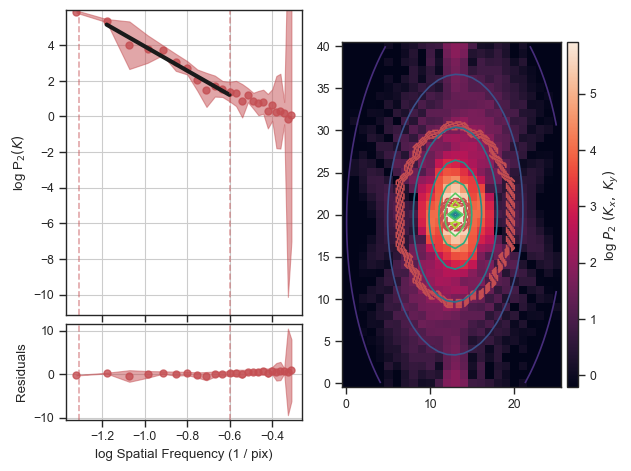

/Users/ekoch/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/ekoch/Library/CloudStorage/Dropbox/code_development/TurbuStat/turbustat/statistics/elliptical_powerlaw.py:253: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     224.6
Date:                Fri, 09 Feb 2024   Prob (F-statistic):           1.14e-07
Time:                        19:17:37   Log-Likelihood:                -3.0058
No. Observations:                  11   AIC:                             10.01
Df Residuals:                       9   BIC:                             10.81
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.5934      0.459     -7.836      0.0

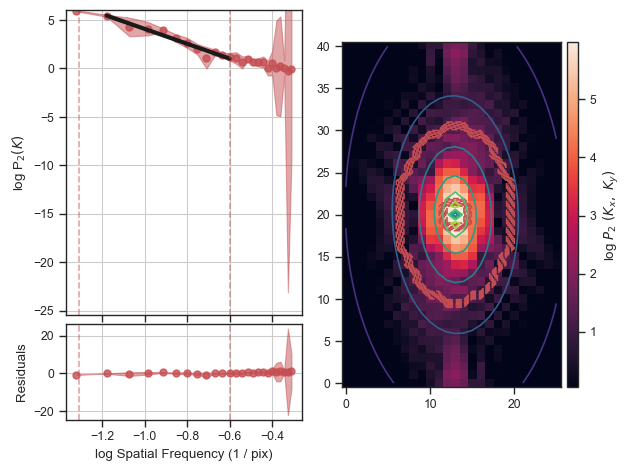

/Users/ekoch/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/ekoch/Library/CloudStorage/Dropbox/code_development/TurbuStat/turbustat/statistics/elliptical_powerlaw.py:253: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     170.3
Date:                Fri, 09 Feb 2024   Prob (F-statistic):           3.75e-07
Time:                        19:17:38   Log-Likelihood:                -5.7751
No. Observations:                  11   AIC:                             15.55
Df Residuals:                       9   BIC:                             16.35
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.3861      0.571     -7.679      0.0

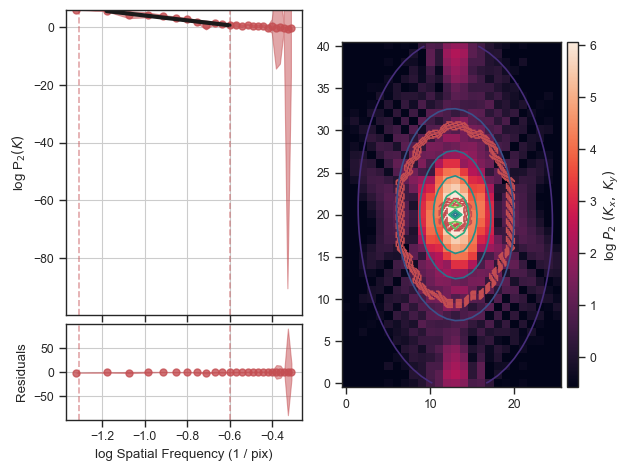

/Users/ekoch/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/ekoch/Library/CloudStorage/Dropbox/code_development/TurbuStat/turbustat/statistics/elliptical_powerlaw.py:253: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     144.2
Date:                Fri, 09 Feb 2024   Prob (F-statistic):           7.66e-07
Time:                        19:17:39   Log-Likelihood:                -6.2808
No. Observations:                  11   AIC:                             16.56
Df Residuals:                       9   BIC:                             17.36
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.9971      0.633     -7.893      0.0

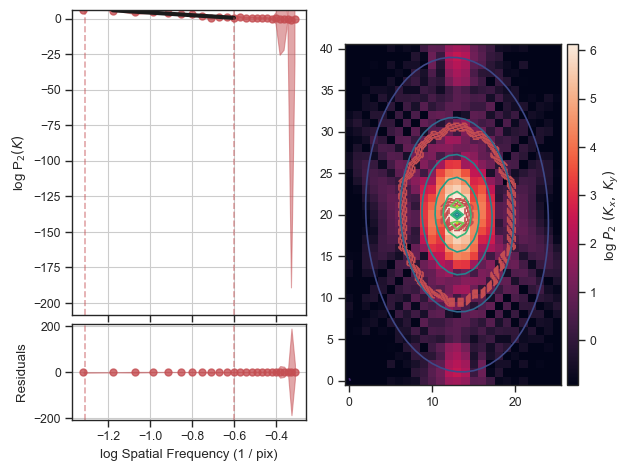

/Users/ekoch/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/ekoch/Library/CloudStorage/Dropbox/code_development/TurbuStat/turbustat/statistics/elliptical_powerlaw.py:253: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     142.5
Date:                Fri, 09 Feb 2024   Prob (F-statistic):           8.05e-07
Time:                        19:17:40   Log-Likelihood:                -6.1474
No. Observations:                  11   AIC:                             16.29
Df Residuals:                       9   BIC:                             17.09
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.9647      0.640     -7.757      0.0

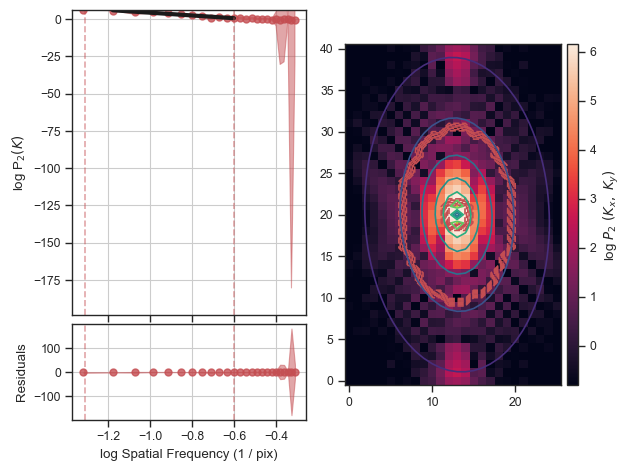

/Users/ekoch/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/ekoch/Library/CloudStorage/Dropbox/code_development/TurbuStat/turbustat/statistics/elliptical_powerlaw.py:253: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     175.6
Date:                Fri, 09 Feb 2024   Prob (F-statistic):           3.30e-07
Time:                        19:17:41   Log-Likelihood:                -3.8705
No. Observations:                  11   AIC:                             11.74
Df Residuals:                       9   BIC:                             12.54
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.8231      0.559     -8.624      0.0

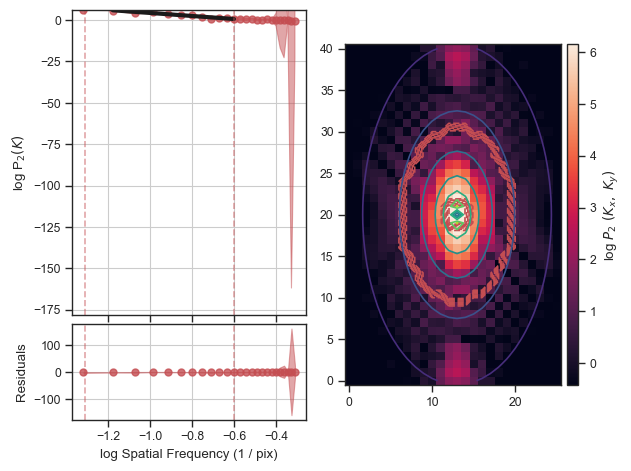

/Users/ekoch/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/ekoch/Library/CloudStorage/Dropbox/code_development/TurbuStat/turbustat/statistics/elliptical_powerlaw.py:253: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     334.0
Date:                Fri, 09 Feb 2024   Prob (F-statistic):           2.01e-08
Time:                        19:17:42   Log-Likelihood:                0.21584
No. Observations:                  11   AIC:                             3.568
Df Residuals:                       9   BIC:                             4.364
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.3916      0.378    -11.622      0.0

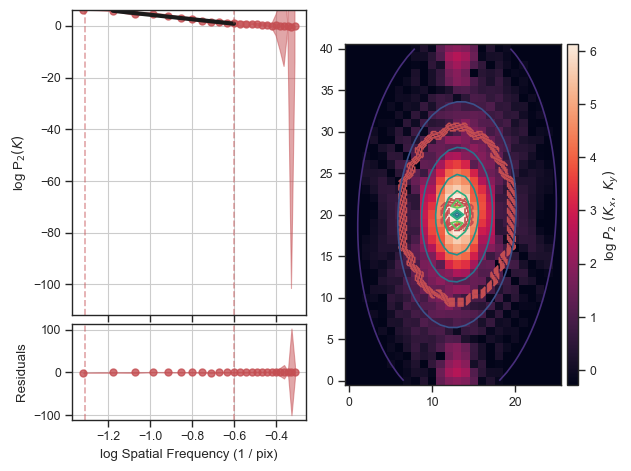

/Users/ekoch/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/ekoch/Library/CloudStorage/Dropbox/code_development/TurbuStat/turbustat/statistics/elliptical_powerlaw.py:253: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     511.9
Date:                Fri, 09 Feb 2024   Prob (F-statistic):           3.05e-09
Time:                        19:17:43   Log-Likelihood:                 3.9137
No. Observations:                  11   AIC:                            -3.827
Df Residuals:                       9   BIC:                            -3.032
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.9214      0.305    -12.873      0.0

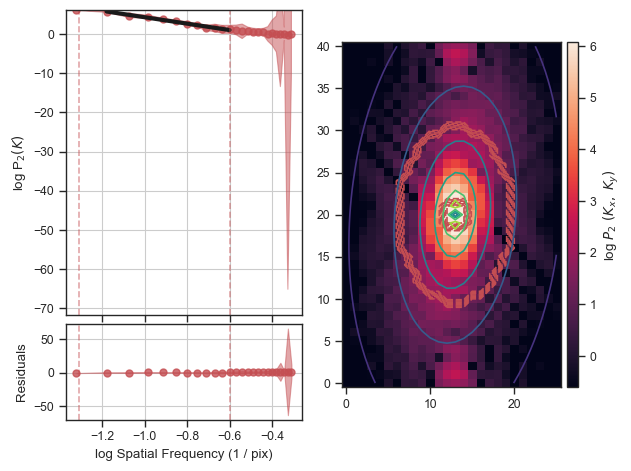

/Users/ekoch/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/ekoch/Library/CloudStorage/Dropbox/code_development/TurbuStat/turbustat/statistics/elliptical_powerlaw.py:253: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     394.7
Date:                Fri, 09 Feb 2024   Prob (F-statistic):           9.63e-09
Time:                        19:17:44   Log-Likelihood:                 2.9090
No. Observations:                  11   AIC:                            -1.818
Df Residuals:                       9   BIC:                            -1.022
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.5129      0.374     -9.388      0.0

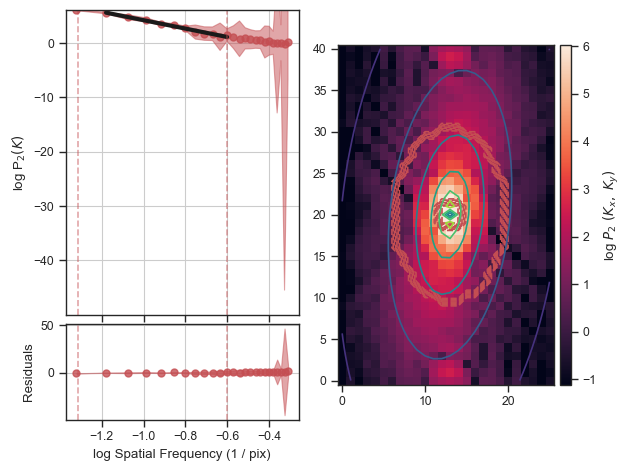

/Users/ekoch/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/ekoch/Library/CloudStorage/Dropbox/code_development/TurbuStat/turbustat/statistics/elliptical_powerlaw.py:253: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     177.6
Date:                Fri, 09 Feb 2024   Prob (F-statistic):           3.14e-07
Time:                        19:17:45   Log-Likelihood:                -1.4154
No. Observations:                  11   AIC:                             6.831
Df Residuals:                       9   BIC:                             7.627
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.2603      0.534     -6.108      0.0

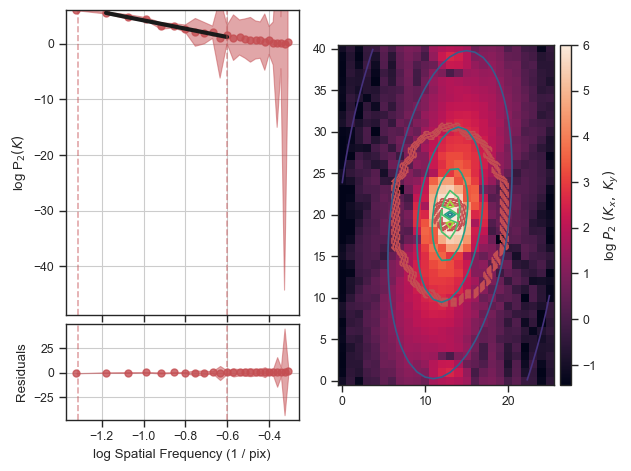

/Users/ekoch/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/ekoch/Library/CloudStorage/Dropbox/code_development/TurbuStat/turbustat/statistics/elliptical_powerlaw.py:253: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     109.0
Date:                Fri, 09 Feb 2024   Prob (F-statistic):           2.50e-06
Time:                        19:17:46   Log-Likelihood:                -3.7014
No. Observations:                  11   AIC:                             11.40
Df Residuals:                       9   BIC:                             12.20
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.1110      0.672     -4.628      0.0

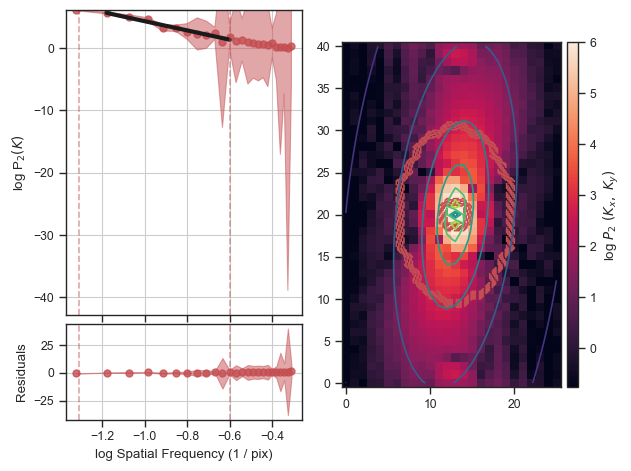

/Users/ekoch/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/ekoch/Library/CloudStorage/Dropbox/code_development/TurbuStat/turbustat/statistics/elliptical_powerlaw.py:253: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     93.58
Date:                Fri, 09 Feb 2024   Prob (F-statistic):           4.71e-06
Time:                        19:17:47   Log-Likelihood:                -4.7812
No. Observations:                  11   AIC:                             13.56
Df Residuals:                       9   BIC:                             14.36
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.0902      0.741     -4.172      0.0

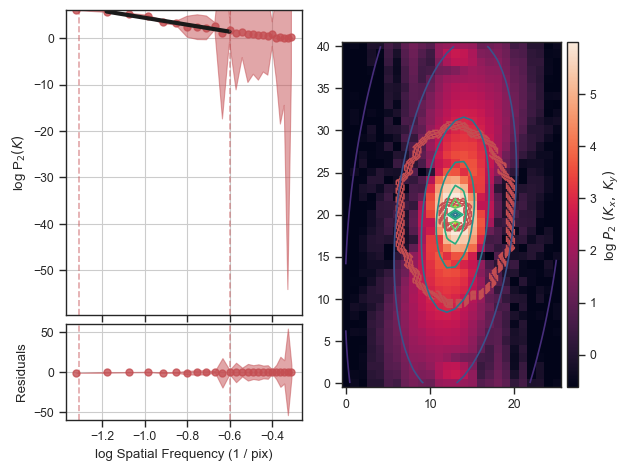

/Users/ekoch/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/ekoch/Library/CloudStorage/Dropbox/code_development/TurbuStat/turbustat/statistics/elliptical_powerlaw.py:253: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     75.81
Date:                Fri, 09 Feb 2024   Prob (F-statistic):           1.12e-05
Time:                        19:17:48   Log-Likelihood:                -4.3793
No. Observations:                  11   AIC:                             12.76
Df Residuals:                       9   BIC:                             13.55
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.9548      0.806     -3.665      0.0

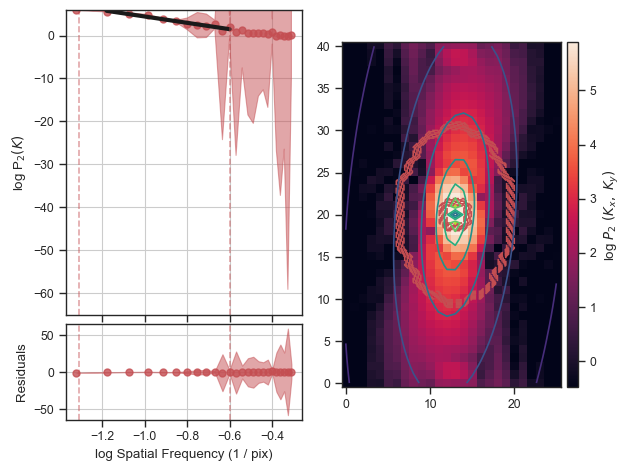

In [24]:
## Check on whether there's Gibbs ringing that's affecting the single dish FFT
from turbustat.statistics import PowerSpectrum

for chan in gbt_cube_specinterp_masked[spec_slicer]:

    pspec_gbt = PowerSpectrum(chan.hdu).run(verbose=True,
                                            radial_pspec_kwargs=dict(method='binned_statistic'),
                                            apodize_kernel='tukey',
                                            high_cut=10**-0.6 / u.pix)

This appears to be relatively stable. Given that the difference is >5%, the expected absolute flux uncertainty, we will apply this scaling during the feathering process.

The scaling is applied to the single dish data, and so, `<1` implies the interferometer recovers a _lower_ apparent flux, while `>1` implies the single dish has a _higher_ apparent flux.



In [25]:
sc_factor

0.9174707753399566

### 6. Feather the cubes

Do the feathering to create the final cubes, using the single dish scaling factor solved for above.

In [26]:
from uvcombine import feather_simple_cube

In [27]:
# gbt_cube_specinterp_masked.header
target_hdr = vla_cube.header.copy()
target_hdr['TIMESYS'] = target_hdr['TIMESYS'].lower()

In [28]:
# Grid the GBT data to the VLA grid
gbt_cube_specinterp_reproj = gbt_cube_specinterp.reproject(target_hdr)

# And specifically apply the same PB coverage
gbt_cube_specinterp_reproj = gbt_cube_specinterp_reproj.with_mask(np.isfinite(vla_cube[0]))

KeyboardInterrupt: 

In [ ]:
np.max(gbt_cube_specinterp_reproj.spectral_axis - vla_cube.spectral_axis)

In [ ]:
vla_cube.spectral_extrema

In [ ]:
# Allow reading in the whole cube.
gbt_cube_specinterp_reproj.allow_huge_operations = True

# Feather with the SD scale factor applied
feathered_cube = feather_simple_cube(vla_cube.to(u.K),
                                     gbt_cube_specinterp_reproj.to(u.K),
                                     allow_lo_reproj=True,
                                     allow_spectral_resample=False,
                                     lowresscalefactor=sc_factor)

# NaN out blank areas post-FFT.
feathered_cube = feathered_cube.with_mask(vla_cube.mask)


In [ ]:
feathered_cube.write(vla_data_path / "ngc6822_C+D_hilores_feathered.fits", overwrite=True)